In [1]:
import pandas as pd                                     
import numpy as np                                   
import os                                               
import matplotlib.pyplot as plt                         
import scipy.stats.mstats as ssm                        
from scipy.stats import gaussian_kde as kde
import random

%matplotlib inline

Our first task is to transform the dataset into something meaningfully that we can use in our classifier. To do that we are going to aggregate the data based on the player and we are going to do that in the following way:
    1. Columns: playerShort, club, leagueCountry, birthday, height, weight and, position just get copied
    2. We drop column: player since the playerShort column is unique
    3. Columns: games, victories, ties, defeats, goals, yellowCards, yellowReds and, redCards get summed up
    4. We drop the photoID column
    5. Then we average the rating of the skin colour
    6. We then drop columns: refNum, refCountry and, Alpha_3
    7. We also drop nIAT, nExp, then average meanIAT, meanExp and calculate new seIAT, seExp based on the variance of the values we used in the averaging of meanIAT and meanExp.




In [50]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv')

Let's check that the data was loaded 

In [51]:
df.head(5)

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


Ok now, let's make the playerShort the index, also let's average the skintone and drop all players that have the skintone as NaN

In [52]:
df.set_index(df.columns[0], inplace=True)
df['skintone']=(df['rater1']+df['rater2'])/2
df.dropna(subset=['skintone'], inplace=True)
players=pd.unique(df.index.values.ravel())

Let's check the number of players left

In [5]:
players.size

1585

In [6]:
data = pd.DataFrame()
labels = pd.DataFrame()

In [7]:
k = 0
for player in players:
    #Copy same columns
    #data.loc[k, 'playerShort'] = player
    data.loc[k, 'club'] =  np.array(df.loc[player, "club"]).flatten()[0]
    data.loc[k, 'leagueCountry'] = np.array(df.loc[player, "leagueCountry"]).flatten()[0]
    data.loc[k, 'height'] = np.array(df.loc[player, "height"]).flatten()[0]
    data.loc[k, 'weight'] = np.array(df.loc[player, "weight"]).flatten()[0]
    data.loc[k, 'position'] = np.array(df.loc[player, "position"]).flatten()[0]
    #Sum up columns 
    data.loc[k, 'games'] =  np.array(df.loc[player, "games"]).sum()
    data.loc[k, 'victories'] =  np.array(df.loc[player, "victories"]).sum()
    data.loc[k, 'ties'] =  np.array(df.loc[player, "ties"]).sum()
    data.loc[k, 'defeats'] =  np.array(df.loc[player, "defeats"]).sum()
    data.loc[k, 'goals'] =  np.array(df.loc[player, "goals"]).sum()
    data.loc[k, 'yellowCards'] =  np.array(df.loc[player, "yellowCards"]).sum()
    data.loc[k, 'yellowReds'] =  np.array(df.loc[player, "yellowReds"]).sum()
    data.loc[k, 'redCards'] =  np.array(df.loc[player, "redCards"]).sum()
    #Averge 2 colums
    data.loc[k, 'meanIAT'] =  np.ma.average(np.ma.array(df.loc[player, "meanIAT"], mask=np.isnan(np.array(df.loc[player, "meanIAT"]))))
    data.loc[k, 'meanExp'] =  np.ma.std(np.ma.array(df.loc[player, "meanIAT"], mask=np.isnan(np.array(df.loc[player, "meanIAT"]))))
    data.loc[k, 'seIAT'] =  np.ma.average(np.ma.array(df.loc[player, "seIAT"], mask=np.isnan(np.array(df.loc[player, "seIAT"]))))
    data.loc[k, 'seExp'] =  np.ma.std(np.ma.array(df.loc[player, "seIAT"], mask=np.isnan(np.array(df.loc[player, "seIAT"]))))
    # get the class
    labels.loc[k, 'skintone'] =  np.array(df.loc[player, 'skintone']).flatten()[0]
    k += 1
    #print(k)
    

Now we need to deal with the text features. Our model does not like text features so we have to encode them as numbers. There are two ways of doing this.
1. We relate each text value to a number
2. For each text value we add a new column and set it to 0 where that text value does not appear and 1 where it appers

In general it it suggested to use the second aproach, but in our case I will use the first aproach for 2 reasons: 
-There are a lot of clubs and that will add a lot of columns
-It will make it very dificult to inspect the feature_importances_

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le1 = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
le.fit(data['leagueCountry'])
le1.fit(data['club'])
le2.fit(data['position'].dropna())

LabelEncoder()

In [9]:
data['leagueCountry'] = le.transform(data['leagueCountry'])
data['club'] = le1.transform(data['club'])
data['position'] = data['position'].fillna(le2.inverse_transform(np.median(le2.transform(data['position'].dropna())).astype(int)))
data['position'] = le2.transform(data['position'])

Our model also does not like NaN values so we will fill them with the median of the respetive column

In [10]:
data['height'] = data['height'].fillna(np.median(data['height'].dropna()))
data['weight'] =data['weight'].fillna(np.median(data['weight'].dropna()))

In [11]:
#data.set_index(data.columns[0], inplace=True)

In [12]:
labels[labels['skintone'] >= 0.5] = 1
labels[labels['skintone'] < 0.5] = 0

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn import metrics
def checkCrossValidationAccuracy (data, labels):
    scores = []
    kf = KFold(len(labels), n_folds=20, shuffle=True, random_state=123)
    for train_index, test_index in kf:
        clf = RandomForestClassifier(n_estimators=15)
        X_train, X_test = data.loc[train_index], data.loc[test_index]
        y_train, y_test = labels.loc[train_index], labels.loc[test_index]
        clf.fit(X_train, y_train['skintone'])
        scores.append(metrics.accuracy_score(y_test['skintone'], clf.predict(X_test)))
        #print(metrics.accuracy_score(y_test['skintone'], clf.predict(X_test)))
        #print(metrics.accuracy_score(y_train['skintone'], clf.predict(X_train)))
    return np.average(scores) 
checkCrossValidationAccuracy(data,labels)

0.78243670886075967

Okay now let's try dropping some cols. Let's drop the club and the leagueCountry as those atributs should not affect the player

In [14]:
data1 = data.drop("leagueCountry", 1)
data1 = data1.drop("club", 1)

In [15]:
checkCrossValidationAccuracy(data1,labels)

0.78363132911392419

It looks like droping thoose features did not increase the accuracy but at the same time it simplified the model

In [16]:
data2 = data1.drop("games", 1)
data2 = data2.drop("victories", 1)
data2 = data2.drop("ties", 1)
data2 = data2.drop("defeats", 1)

In [17]:
data2.head()

,height,weight,position,goals,yellowCards,yellowReds,redCards,meanIAT,meanExp,seIAT,seExp
0,177.0,72.0,0,10.0,21.0,1.0,2.0,0.356667,0.021445,0.000857,0.001225
1,179.0,82.0,11,88.0,33.0,0.0,2.0,0.326257,0.056153,0.002318,0.006582
2,182.0,71.0,1,9.0,19.0,0.0,0.0,0.346459,0.031416,0.000652,0.003251
3,187.0,80.0,6,28.0,50.0,4.0,3.0,0.360355,0.028830,0.000445,0.000850
4,180.0,68.0,4,11.0,34.0,0.0,0.0,0.345591,0.030618,0.000413,0.000742


In [18]:
checkCrossValidationAccuracy(data2,labels)

0.78926424050632926

In [19]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(data2, labels['skintone'])
clf.feature_importances_

array([ 0.07363683,  0.07459487,  0.06031796,  0.08046975,  0.10674138,
        0.03453149,  0.02975439,  0.14867619,  0.15885095,  0.1202705 ,
        0.1121557 ])

Let's try to join the yellowReds and redCards columns

In [20]:
data3 = data2
data3['redCards'] = data3['redCards'] + data3['yellowReds']
data3 = data3.drop("yellowReds", 1)

In [21]:
checkCrossValidationAccuracy(data3,labels)

0.78181170886075957

In [22]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(data3, labels['skintone'])
clf.feature_importances_

array([ 0.07023286,  0.06888325,  0.0638513 ,  0.08191799,  0.11153677,
        0.04694772,  0.15825306,  0.13109809,  0.14341266,  0.1238663 ])

Let's also try to remove the position 

In [23]:
data4 = data3.drop("position", 1)

In [24]:
checkCrossValidationAccuracy(data4,labels)

0.79880537974683563

We can also try to join the yellow cards and red cards in one column named cards

In [25]:
data5 = data4
data5['cards'] = data5['redCards'] + data5['yellowCards']
data5 = data5.drop('redCards', 1)
data5 = data5.drop('yellowCards', 1)
data5.head()

,height,weight,goals,meanIAT,meanExp,seIAT,seExp,cards
0,177.0,72.0,10.0,0.356667,0.021445,0.000857,0.001225,24.0
1,179.0,82.0,88.0,0.326257,0.056153,0.002318,0.006582,35.0
2,182.0,71.0,9.0,0.346459,0.031416,0.000652,0.003251,19.0
3,187.0,80.0,28.0,0.360355,0.028830,0.000445,0.000850,57.0
4,180.0,68.0,11.0,0.345591,0.030618,0.000413,0.000742,34.0


In [26]:
checkCrossValidationAccuracy(data5,labels)

0.78428006329113931

In [27]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(data5, labels['skintone'])
clf.feature_importances_

array([ 0.08219373,  0.08886993,  0.09041598,  0.18698277,  0.1580437 ,
        0.14154238,  0.13088037,  0.12107113])

The final simplification that we can try is to eleminate all data that is not connected to the cards

In [28]:
data6 = data5.drop('height', 1)
data6 = data6.drop("weight", 1)

In [29]:
checkCrossValidationAccuracy(data6,labels) 

0.78551424050632934

In [30]:
clf = RandomForestClassifier(n_estimators=15)
clf.fit(data6, labels['skintone'])
clf.feature_importances_

array([ 0.12631288,  0.21017548,  0.20426664,  0.15873484,  0.16351017,
        0.13699999])

## PART 2

In [31]:
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

First we will turn the skintone column into binary values, 1 for dark skintone, 0 for light

In [53]:
part2df = df
part2df['skintone'] = part2df['skintone'].apply(lambda x: 1 if x>=0.5 else 0)
part2df.head()

,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone
playerShort,,,,,,,,,,,,,,,,,,,,,
lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0
john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,1
aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0
aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0
alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1


We only want the numeric data

In [54]:
part2df = part2df._get_numeric_data()

We will now discard the referee data

In [55]:
part2df.drop('refNum', axis=1, inplace=True)
part2df.drop('refCountry', axis=1, inplace=True)

In [56]:
part2df.head()

,height,weight,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,rater2,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,skintone
playerShort,,,,,,,,,,,,,,,,,,,
lucas-wilchez,177.0,72.0,1,0,0,1,0,0,0,0,0.25,0.50,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0
john-utaka,179.0,82.0,1,0,0,1,0,1,0,0,0.75,0.75,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,1
aaron-hughes,182.0,71.0,1,0,0,1,0,0,0,0,0.25,0.00,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0
aleksandar-kolarov,187.0,80.0,1,1,0,0,0,0,0,0,0.00,0.25,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0
alexander-tettey,180.0,68.0,1,0,0,1,0,0,0,0,1.00,1.00,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1


We then drop rows that contain at least one NaN, because KMeans can't work with that

In [57]:
part2df.dropna(inplace=True)

In [58]:
#df_train, df_test = sklearn.cross_validation.train_test_split(part2df, train_size=0.6)

kmean = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1)
kmean.fit(part2df)
labels = kmean.labels_
kmean.cluster_centers_.shape

(2, 19)

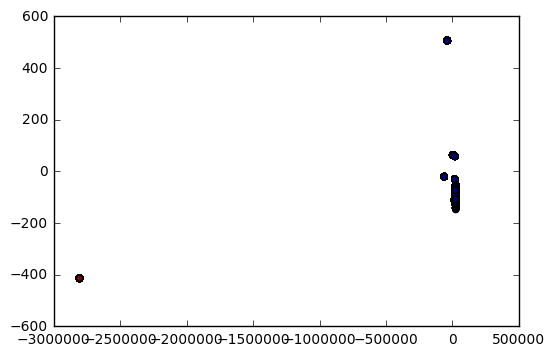

In [59]:
from sklearn.decomposition import PCA

# Create a PCA model.
pca_2 = PCA(2)
# Fit the PCA model on the numeric columns from earlier.
plot_columns = pca_2.fit_transform(part2df)
# Make a scatter plot of each game, shaded according to cluster assignment.
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
# Show the plot.
plt.show()

In [60]:
sklearn.metrics.silhouette_score(kmean, kmean.labels_)

AttributeError: 'KMeans' object has no attribute 'shape'

In [63]:
part2df.corr()['skintone']

height        -0.038431
weight        -0.025737
games         -0.019337
victories     -0.020237
ties          -0.005220
defeats       -0.017737
goals          0.008683
yellowCards   -0.024667
yellowReds    -0.002553
redCards       0.003951
rater1         0.852336
rater2         0.850048
meanIAT       -0.078318
nIAT           0.022414
seIAT          0.048178
meanExp       -0.062495
nExp           0.022530
seExp          0.058128
skintone       1.000000
Name: skintone, dtype: float64